# <div style="background-color:#7289DA;font-family:calibri;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px; padding:5px">1. Introduction</div>

## Problem Statement
In high-stakes industries like aviation, equipment failure is not an option. The breakdown of a critical component, such as a jet engine, can lead to catastrophic safety events, significant operational disruptions, and exorbitant costs. Traditional maintenance strategies often rely on fixed schedules, which can result in either servicing equipment too early (wasting resources) or too late (risking failure). Predictive Maintenance (PdM) offers a data-driven solution, aiming to forecast failures before they occur, allowing for timely and efficient interventions.


## Objective
The primary objective of this notebook is to develop a deep learning regression model to accurately predict the Remaining Useful Life (RUL) of turbofan engines. By leveraging time-series sensor data, we will build a Long Short-Term Memory (LSTM) network capable of understanding the degradation patterns of an engine over its lifespan. The final model will output a specific number representing the remaining operational cycles before an engine is likely to fail.

## The Dataset
We will be using the renowned NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) dataset, specifically the FD001 subset. This dataset is a benchmark for predictive maintenance tasks and contains simulated run-to-failure data for a fleet of 100 turbofan engines. For each engine, the data consists of:

* Engine ID: A unique identifier for each engine unit.
* Time in Cycles: The operational cycle number.
* Operational Settings: Three settings that influence engine performance.
*  Sensor Measurements: 21 sensor readings capturing various engine parameters (e.g., temperature, pressure, fan speed).

## Our Methodology
This notebook will follow a structured data science workflow:

* Setup and Data Loading: Import necessary libraries and load the dataset.
* Feature Engineering & EDA: Calculate the RUL for the training data, clean the data by removing uninformative columns, and explore its characteristics through visualization.
* Data Preprocessing: Scale the features and structure the data into sequences suitable for an LSTM model.
* LSTM Model Building & Training: Construct, compile, and train our deep learning model.
* Model Evaluation: Assess the model's performance on the test set using metrics like RMSE.
* Hyperparameter Tuning (Bonus): Automatically search for the optimal model parameters to further improve performance.

# <div style="background-color:#7289DA;font-family:calibri;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px; padding:5px">2. Setup and Data Loading</div>

This section covers the initial technical setup of our notebook. We'll import the essential libraries and then load the training, test, and ground truth datasets into pandas DataFrames for exploration and analysis.

## Import Libraries

First, let's import all the necessary libraries. We'll also set an environment variable to suppress non-critical TensorFlow logging messages for a cleaner output.

In [1]:
# Suppress TensorFlow C++ logging (must be called before importing tensorflow)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for preprocessing
from sklearn.preprocessing import MinMaxScaler

# TensorFlow and Keras for building the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# KerasTuner for hyperparameter optimization
import keras_tuner as kt

# Set some visualization options for better plots
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-pastel')

print("Libraries imported successfully!")

2025-08-26 08:40:27.109032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756197627.293194      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756197627.343284      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully!


## Load the Datasets

Now, we will load the three key files. The data is space-separated and doesn't contain a header row, so we'll specify that during the loading process.

In [ ]:
# Define file paths
train_path = 'CMaps/train_FD001.txt'
test_path = 'CMaps/test_FD001.txt'
rul_path = 'CMaps/RUL_FD001.txt'

# Load the data using pandas
train_df = pd.read_csv(train_path, sep=' ', header=None)
test_df = pd.read_csv(test_path, sep=' ', header=None)
truth_df = pd.read_csv(rul_path, sep=' ', header=None)

print("Data loaded successfully!")

Data loaded successfully!


## Initial Inspection and Cleanup
The raw data comes without column names and often includes extra empty columns at the end due to trailing spaces in the files. We'll clean this up by dropping any unnecessary columns and assigning descriptive names. Using errors='ignore' makes our code robust, as it won't fail if the extra columns aren't present.

In [3]:
# Drop the last two columns if they exist, otherwise ignore the error
train_df.drop(columns=[26, 27], inplace=True, errors='ignore')
test_df.drop(columns=[26, 27], inplace=True, errors='ignore')

# Define descriptive column names
column_names = [
    'engine_id', 'time_in_cycles', 'setting_1', 'setting_2', 'setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
    'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12',
    'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18',
    'sensor_19', 'sensor_20', 'sensor_21'
]

# Assign the column names to the train and test dataframes
train_df.columns = column_names
test_df.columns = column_names

# FIX: Drop the extra empty column from the ground truth data
truth_df.drop(columns=[1], inplace=True, errors='ignore')

# For the ground truth data, now we can name the single column 'RUL'
truth_df.columns = ['RUL']

print("Columns named and cleaned.")

Columns named and cleaned.


## DataFrames Overview
Let's take a quick look at the cleaned training DataFrame to ensure everything has loaded correctly.

###  Training Data


In [4]:
# Display the first 5 rows of the training data
train_df.head()

,engine_id,time_in_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
# Get a concise summary of the training dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   engine_id       20631 non-null  int64  
 1   time_in_cycles  20631 non-null  int64  
 2   setting_1       20631 non-null  float64
 3   setting_2       20631 non-null  float64
 4   setting_3       20631 non-null  float64
 5   sensor_1        20631 non-null  float64
 6   sensor_2        20631 non-null  float64
 7   sensor_3        20631 non-null  float64
 8   sensor_4        20631 non-null  float64
 9   sensor_5        20631 non-null  float64
 10  sensor_6        20631 non-null  float64
 11  sensor_7        20631 non-null  float64
 12  sensor_8        20631 non-null  float64
 13  sensor_9        20631 non-null  float64
 14  sensor_10       20631 non-null  float64
 15  sensor_11       20631 non-null  float64
 16  sensor_12       20631 non-null  float64
 17  sensor_13       20631 non-null 

In [6]:
# Generate descriptive statistics for the training data
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
engine_id,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time_in_cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


### Test Data


In [7]:
# Display the first 5 rows of the test data
test_df.head()

,engine_id,time_in_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


### Drop Constant Columns

In [8]:
# First, get the summary statistics
stats = train_df.describe().transpose()

# Find columns where the standard deviation is 0
constant_cols = stats[stats['std'] == 0].index.tolist()

print(f"Constant columns found: {constant_cols}")

# Drop these columns from both train and test sets
train_df.drop(columns=constant_cols, inplace=True)
test_df.drop(columns=constant_cols, inplace=True)

print("Constant columns dropped successfully.")

Constant columns found: ['setting_3', 'sensor_18', 'sensor_19']
Constant columns dropped successfully.


###  Ground Truth Data


In [9]:
# Display the first 5 rows of the ground truth RUL data
truth_df.head()

,RUL
0,112
1,98
2,69
3,82
4,91


# <div style="background-color:#7289DA;font-family:calibri;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px; padding:5px">3. Feature Engineering & Exploratory Data Analysis (EDA)</div>

In this section, we will prepare our data for modeling. The workflow will be:

* Feature Engineering: Create our target variable, the Remaining Useful Life (RUL).
* Feature Selection: Remove uninformative columns that provide no predictive value.
* Feature Scaling: Scale the data to prepare it for our neural network model.
* Exploratory Data Analysis: Visualize the prepared data to understand its characteristics.

  
## Feature Engineering: Calculate RUL
The first step is to create our target variable. For the "run-to-failure" training data, the RUL is the number of cycles remaining before the engine's final operational cycle. The goal of our model is to predict the RUL. For the training set, we can calculate this directly. The RUL is the number of cycles remaining before an engine's final failure. We'll find the last cycle for each engine and subtract the current cycle number.



In [10]:
# Calculate the maximum cycle for each engine in the training set
max_cycles_df = train_df.groupby('engine_id')['time_in_cycles'].max().reset_index()
max_cycles_df.columns = ['engine_id', 'max_cycles']

# Merge the max cycle information back into the training dataframe
train_df = pd.merge(train_df, max_cycles_df, on='engine_id', how='left')

# Calculate RUL for each row
train_df['RUL'] = train_df['max_cycles'] - train_df['time_in_cycles']

# Drop the 'max_cycles' column as it's no longer needed for training
train_df.drop(columns=['max_cycles'], inplace=True)

print("RUL column calculated and added to the training data.")

RUL column calculated and added to the training data.


## Feature Selection: Drop Uninformative Columns
Not all features are useful. We will remove columns that have no variance (constant columns) or no significant linear relationship with the RUL. This simplifies the model and can improve performance by reducing noise.

In [11]:
# Identify columns with zero standard deviation (constant columns)
stats = train_df.describe().transpose()
constant_cols = stats[stats['std'] == 0].index.tolist()

# Identify columns with near-zero correlation to RUL from previous analysis
low_corr_cols = ['sensor_1', 'sensor_5', 'sensor_10', 'sensor_16']

# Combine the lists of columns to drop
cols_to_drop = list(set(constant_cols + low_corr_cols))

# Drop these columns from both the training and test sets
train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped the following uninformative columns: {cols_to_drop}")

Dropped the following uninformative columns: ['sensor_10', 'sensor_16', 'sensor_5', 'sensor_1']


### Feature Scaling
Neural networks train more efficiently when input features are on a similar scale. We will use MinMaxScaler to scale our feature values to a range between 0 and 1.

Note: We are performing this step before visualization. This means the y-axis in the subsequent sensor plots will represent the scaled value [0, 1] rather than the original sensor units.

In [12]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Dynamically select the feature columns to be scaled
# These are all columns except the identifiers and the target variable
feature_cols = train_df.columns.drop(['engine_id', 'time_in_cycles', 'RUL']).tolist()

# Fit the scaler on the training data and transform it
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])

# Transform the test data using the same fitted scaler
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

print("Feature scaling applied successfully to both train and test sets.")

Feature scaling applied successfully to both train and test sets.


## Data Visualization
Now, let's visualize the cleaned data to better understand its characteristics.

### Distribution of Engine Lifecycles
This plot shows the operational lifespan for the engines in our training set. This visualization uses the original, unscaled cycle counts for better interpretability.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


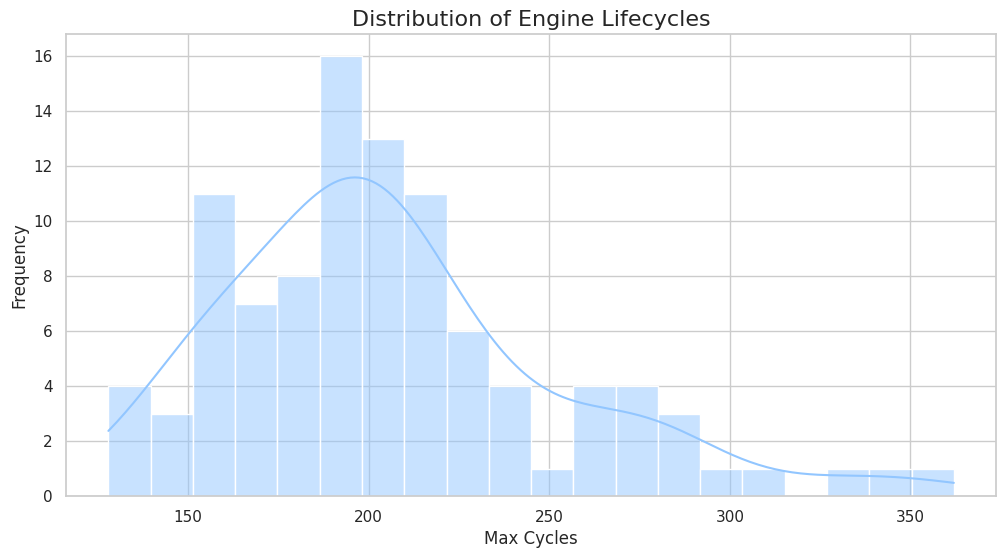

In [13]:
# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Plot the distribution of max cycles
sns.histplot(max_cycles_df['max_cycles'], bins=20, kde=True)

plt.title('Distribution of Engine Lifecycles', fontsize=16)
plt.xlabel('Max Cycles')
plt.ylabel('Frequency')
plt.show()

###  Sensor Readings Over Time
Let's plot some of the highly-correlated remaining sensors for a single engine to see the degradation trends.

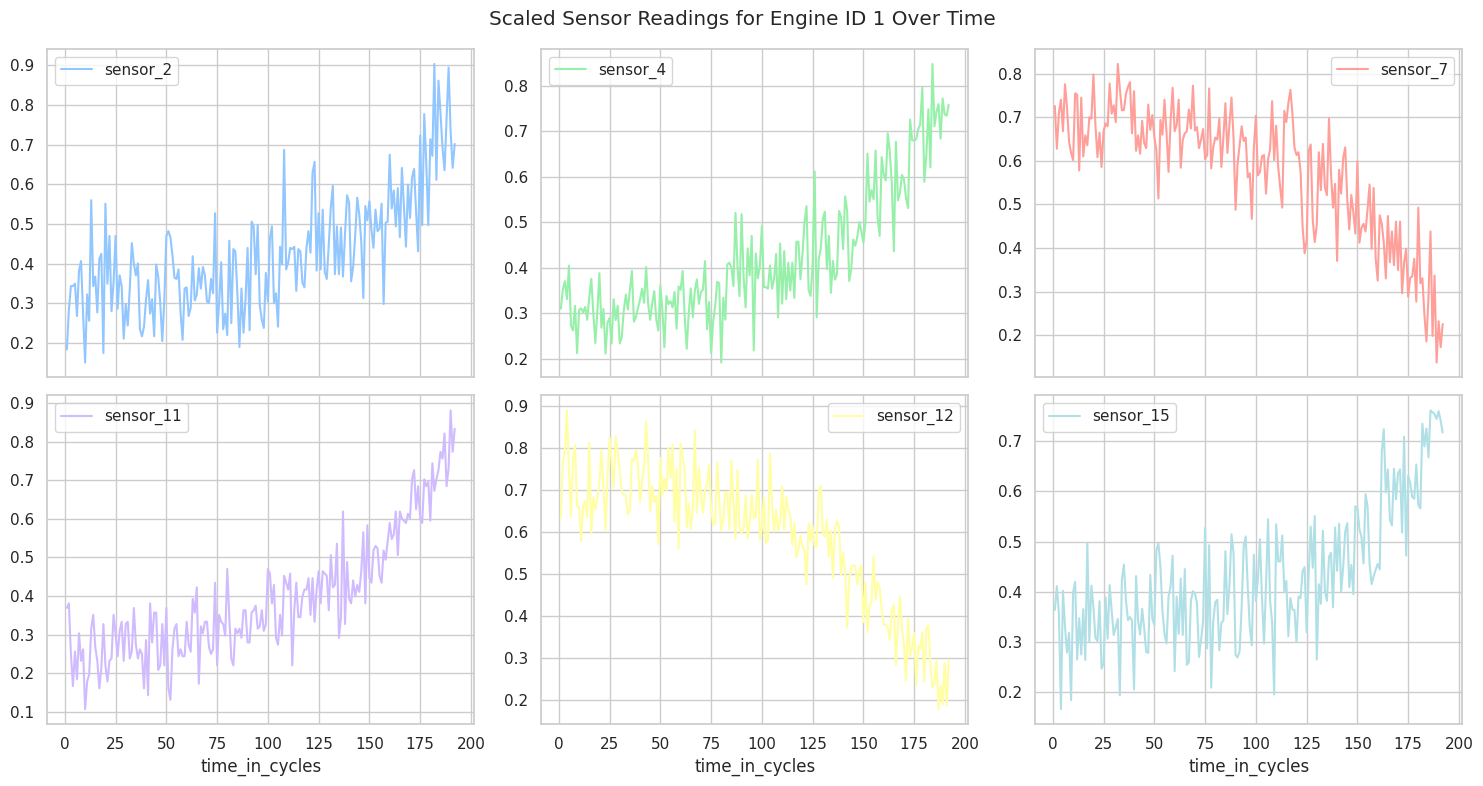

In [14]:
# Select one engine to visualize
engine_to_plot = train_df[train_df['engine_id'] == 1]

# Define some of the highly-correlated sensors that remain in our dataset
sensors_to_plot = ['sensor_2', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_12', 'sensor_15']

# Create the plot
engine_to_plot.plot(x='time_in_cycles', y=sensors_to_plot, subplots=True, layout=(2, 3), figsize=(15, 8), title='Scaled Sensor Readings for Engine ID 1 Over Time')
plt.tight_layout()
plt.show()

###  Correlation Matrix Heatmap


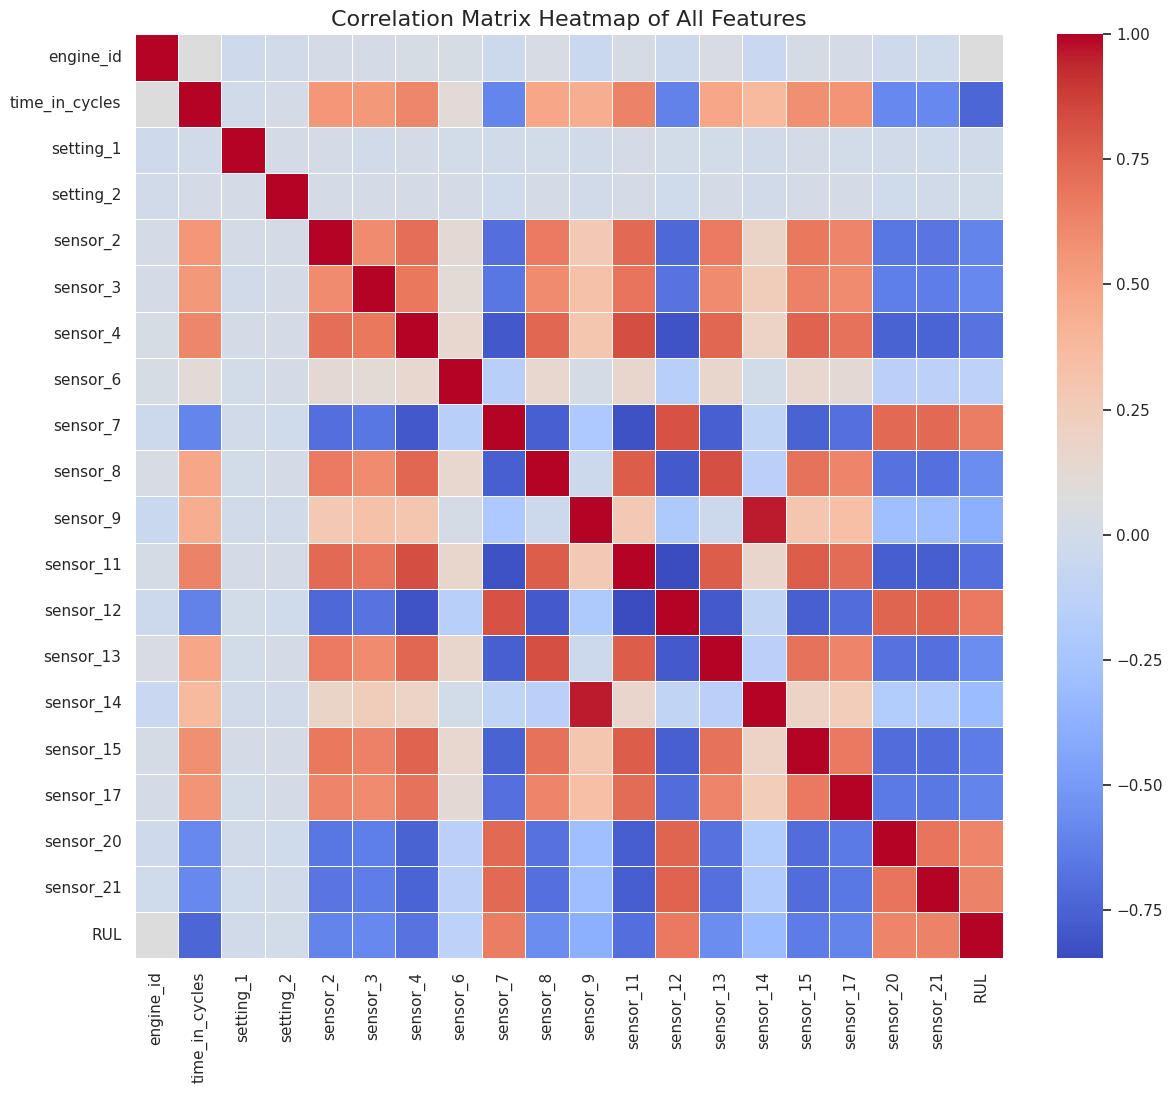

In [15]:
# Calculate the correlation matrix on the cleaned data
corr_matrix = train_df.corr()

# Create a figure for the heatmap
plt.figure(figsize=(14, 12))

# Generate the heatmap using seaborn
# We use a diverging colormap ('coolwarm') to easily distinguish positive (warm colors)
# and negative (cool colors) correlations.
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)

plt.title('Correlation Matrix Heatmap of All Features', fontsize=16)
plt.show()

###  Feature Correlation with RUL 
Finally, let's examine the feature correlations now that we've removed the uninformative columns. This confirms we are left with a strong set of predictive features.

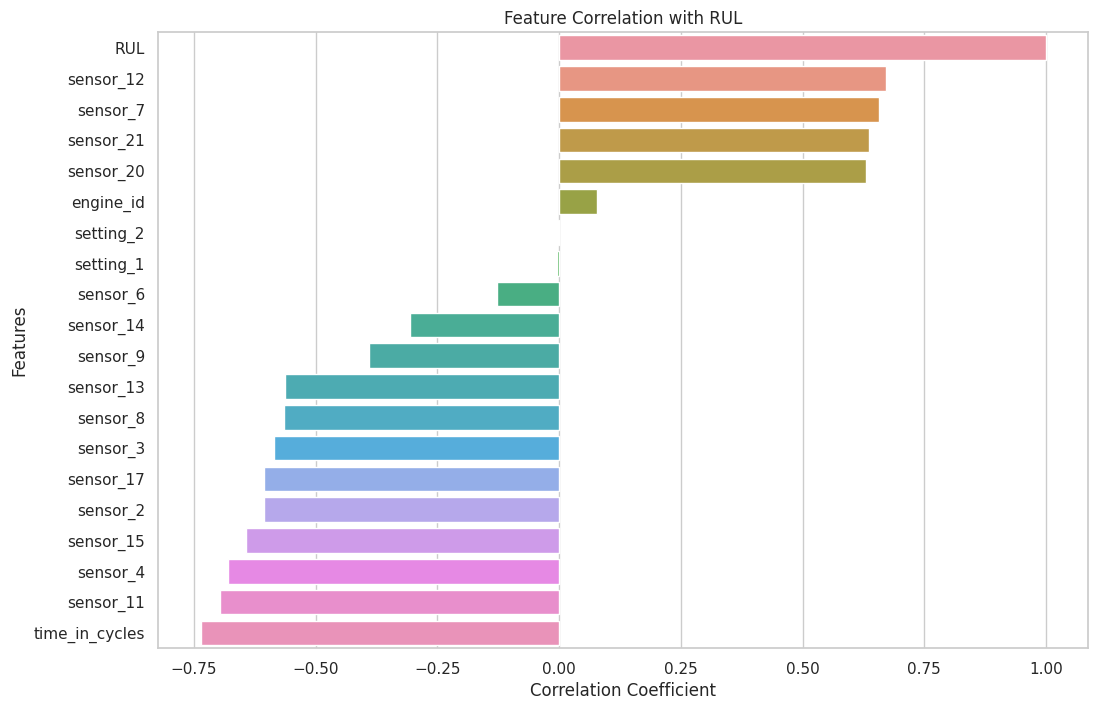

In [16]:
# Get correlations with the 'RUL' column
rul_correlations = corr_matrix['RUL'].sort_values(ascending=False)

# Create a figure for the bar plot
plt.figure(figsize=(12, 8))

# Plot the correlations
sns.barplot(x=rul_correlations.values, y=rul_correlations.index)
plt.title('Feature Correlation with RUL')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

# <div style="background-color:#7289DA;font-family:calibri;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px; padding:5px">4. Model Evaluation Metrics</div>
   
Before we build our model, it's crucial to define how we will measure its success. Choosing the right evaluation metrics ensures that we optimize for what truly matters in a predictive maintenance context. Since our goal is to predict the Remaining Useful Life (RUL), a continuous value, this is a regression problem.

Here are the key metrics we will use to evaluate our model.

## Root Mean Squared Error (RMSE) - The Primary Metric
RMSE will be our main metric for optimizing the model. It is the square root of the average of the squared differences between the predicted RUL and the actual RUL.

What it tells us: It measures the average magnitude of our model's prediction errors, expressed in the same unit as our target variable—in this case, cycles. An RMSE of 15 means our model's predictions are, on average, off by about 15 cycles.

Why it's important for this case: The "squaring" step gives a much higher weight to large errors. In predictive maintenance, a large error (e.g., predicting 100 cycles remain when only 10 do) is far more dangerous than a small error. RMSE's sensitivity to large errors aligns perfectly with our goal of avoiding catastrophic failures. Our main objective is to minimize the RMSE.

## R-squared (R²) Score - For Goodness of Fit
The R² score, or the coefficient of determination, provides a relative measure of how well our model's predictions approximate the actual values.

What it tells us: It represents the proportion of the variance in the RUL that can be explained by our model's features. The score ranges from 1.0 (perfect prediction) down to 0.0 or even negative values.

How to interpret it: An R² of 0.85 means that our model can explain 85% of the variability in the engine's RUL. It helps us understand the overall explanatory power of our model beyond just the average error.

## Mean Absolute Error (MAE) - For Context
MAE is the average of the absolute differences between the predicted and actual RUL.

What it tells us: Like RMSE, it's also measured in cycles. An MAE of 12 means our predictions are, on average, 12 cycles away from the true value.

Why it's useful for comparison: Unlike RMSE, MAE treats all errors equally (no squaring). If our model's RMSE is significantly higher than its MAE, it suggests that our model is making a few very large errors, which might be worth investigating.

## NASA Scoring
In real-world scenarios, the cost of being wrong is not always symmetrical. For the NASA Turbofan dataset, a specific scoring function is often used that penalizes late predictions much more heavily than early predictions.

Early Prediction (Predicted RUL < Actual RUL): This is safe. You perform maintenance earlier than needed, which costs money but prevents failure.

Late Prediction (Predicted RUL > Actual RUL): This is dangerous. The engine fails before you predicted, which could be catastrophic.

While we will focus on RMSE for our model training, it's important to remember that a truly effective predictive maintenance system would ultimately be judged on a business-centric metric like this.

The scoring function used for the NASA Turbofan (C-MAPSS) dataset is a crucial part of the challenge because it's designed to mirror the real-world costs of maintenance decisions. Unlike standard metrics like RMSE, this score is asymmetric, meaning it penalizes late predictions far more harshly than early ones.

### The Core Concept: Early vs. Late Predictions
The score is based on the error, or difference (d), between the predicted RUL and the actual RUL for each engine in the test set.

d = Predicted RUL − Actual RUL

There are two distinct scenarios:

Early Prediction (Safe, but inefficient): If the model predicts failure will happen sooner than it actually does, d is negative. This leads to performing maintenance before it's strictly necessary. The cost is lower, involving things like replacing a part that still had some useful life left.

Late Prediction (Dangerous and expensive): If the model predicts failure will happen later than it actually does, d is positive. This is the worst-case scenario where the engine fails unexpectedly. The cost is much higher, involving catastrophic failure, secondary damage, and unplanned downtime.

### The Mathematical Formula
The total score (s) is the sum of scores for each of the n engines in the test set. The formula is designed to reflect the asymmetric cost:

s= 
i=1
∑
n
​
 { 
e 
−d 
i
​
 /13
 −1
e 
d 
i
​
 /10
 −1
​
  
for d 
i
​
 <0 (Early)
for d 
i
​
 ≥0 (Late)
​
 
Let's break down the two parts:

For Early Predictions (d 
i
​
 <0): The score is calculated with e 
−d/13
 −1. Because d is negative, the exponent is a small positive number. The exponential function grows slowly in this region, resulting in a small penalty. The denominator 13 moderates this penalty, making it grow gently.

For Late Predictions (d 
i
​
 ≥0): The score is calculated with e 
d/10
 −1. Because d is positive, the exponent is positive. The exponential function grows very rapidly, resulting in a large, punishing penalty. The smaller denominator 10 makes this penalty grow even faster.

As the plot clearly shows, the penalty for being late (positive error) skyrockets compared to the much smaller penalty for being early (negative error).

### Why This Score Matters
This custom scoring function forces a model to learn the business context of the problem. A model that simply minimizes RMSE might have an equal number of early and late predictions. However, a model optimized for this score will be cautiously pessimistic. It learns that it's far better to be a little bit early with a prediction than to be even slightly late.

This directly aligns the model's performance with the primary goals of a real-world predictive maintenance program: prioritizing safety and avoiding catastrophic failure, even at the cost of some minor operational inefficiency.

# <div style="background-color:#7289DA;font-family:calibri;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px; padding:5px">5. Baseline Model: Random Forest Regressor</div>

Before building a complex deep learning model like an LSTM, it's a best practice to first create a simpler baseline model. This baseline gives us a performance benchmark; any advanced model we build must significantly outperform it to justify its complexity.

For our baseline, we will use a Random Forest Regressor. It's a powerful and robust model that works well on tabular data without requiring the complex data sequencing needed for LSTMs.

## Data Preparation for the Baseline Model
Random Forest treats each row as an independent data point, so we don't need to create time-series sequences. We can use the data in its current tabular format. We will separate our features (X) from our target (y) and then split the training data into a new training and validation set to evaluate this model.

In [17]:
from sklearn.model_selection import train_test_split

# Define the features (X) and target (y)
features = train_df.columns.drop(['engine_id', 'time_in_cycles', 'RUL'])
X = train_df[features]
y = train_df['RUL']

# Split the data into training and validation sets
# We'll use 80% for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")

Training features shape: (16504, 17)
Validation features shape: (4127, 17)


## Model Training
Now, we'll import the RandomForestRegressor from Scikit-learn, instantiate it with some sensible default parameters, and train it on our newly created training set.

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate the Random Forest Regressor model
# n_estimators is the number of trees in the forest.
# n_jobs=-1 allows the model to use all available CPU cores for faster training.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
print("Training the Random Forest model...")
rf_model.fit(X_train, y_train)
print("Training complete.")

Training the Random Forest model...
Training complete.


## Baseline Model Evaluation
Let's evaluate our trained Random Forest model on the validation set (X_val, y_val) to see how well it performs. We'll use the same metrics (RMSE and R²) that we defined for our main project goal.

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the validation set
y_pred_val = rf_model.predict(X_val)

# Calculate the Root Mean Squared Error (RMSE)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation RMSE: {rmse_val:.2f}")

# Calculate the R-squared (R2) Score
r2_val = r2_score(y_val, y_pred_val)
print(f"Validation R-squared Score: {r2_val:.2f}")

Validation RMSE: 41.47
Validation R-squared Score: 0.62


## NASA Asymmetric Scoring Function
Here is a Python function that implements the specific scoring formula for the C-MAPSS dataset. It takes the true RUL values and the predicted RUL values as input and returns the final score.

In [20]:
def nasa_score(y_true, y_pred):
    """
    Calculates the NASA C-MAPSS scoring function.

    Args:
        y_true (array-like): The actual RUL values.
        y_pred (array-like): The predicted RUL values.

    Returns:
        float: The total score.
    """
    score = 0
    # Calculate the difference d for each prediction
    d = y_pred - y_true
    
    # Apply the asymmetric scoring function
    for d_i in d:
        if d_i < 0:
            # Penalty for early predictions
            score += np.exp(-d_i / 13.0) - 1
        else:
            # Heavier penalty for late predictions
            score += np.exp(d_i / 10.0) - 1
            
    return score

# Calculate the NASA score on the validation set predictions
nasa_score_val = nasa_score(y_val, y_pred_val)

print(f"Validation NASA Score: {nasa_score_val:.2f}")

Validation NASA Score: 31014027.07


# <div style="background-color:#7289DA;font-family:calibri;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px; padding:5px">6. Baseline Model with Clipped RUL</div>

## Data Preparation: Piecewise RUL Clipping
A key insight for this dataset is that engine degradation is not linear throughout the entire lifecycle. In the early stages of an engine's life, the sensor readings are stable and show no signs of wear. The degradation only becomes apparent in the later stages.

By clipping the RUL at a certain maximum value, we are simplifying the problem for the model. We are essentially telling it: "Don't worry about the early 'healthy' phase where there's no signal. Treat all engines with a long life remaining as being in a general 'good' state. Only start learning the precise RUL when the engine enters its degradation phase."

### Choosing the Clipping Value
Based on extensive research and public analyses of this dataset, a suitable clipping value is typically between 120 and 130 cycles. We will use 125 as our clipping threshold. This focuses the model's attention on the part of the engine's life where the sensor data contains the most predictive information about the impending failure.

### Applying the Clipping
We can apply this transformation easily using pandas.

In [21]:
# Define the clipping value
RUL_CLIP_VALUE = 125

# Clip the RUL values in the training data
train_df['RUL'] = train_df['RUL'].clip(upper=RUL_CLIP_VALUE)

print(f"RUL values have been clipped at a maximum of {RUL_CLIP_VALUE}.")

RUL values have been clipped at a maximum of 125.


### Visualizing the Effect of Clipping
To understand what this transformation does, let's visualize the RUL for a single engine before and after clipping. The new RUL stays constant at 125 during the "healthy" phase and only begins to decrease as the engine approaches failure.

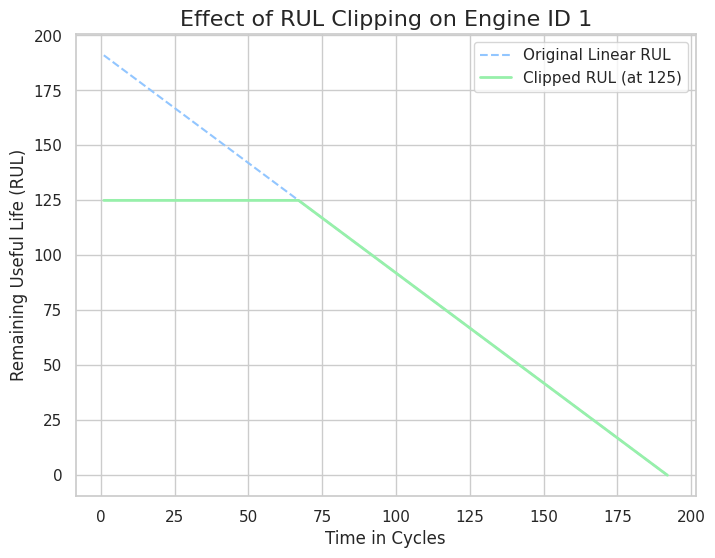

In [22]:
# To visualize, we'll temporarily recalculate the original RUL for one engine
engine_to_plot = train_df[train_df['engine_id'] == 1].copy()
max_cycles_engine_1 = engine_to_plot['time_in_cycles'].max()
original_rul = max_cycles_engine_1 - engine_to_plot['time_in_cycles']

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(engine_to_plot['time_in_cycles'], original_rul, label='Original Linear RUL', linestyle='--')
plt.plot(engine_to_plot['time_in_cycles'], engine_to_plot['RUL'], label=f'Clipped RUL (at {RUL_CLIP_VALUE})', linewidth=2)

plt.title('Effect of RUL Clipping on Engine ID 1', fontsize=16)
plt.xlabel('Time in Cycles')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.grid(True)
plt.show()

Now that we have preprocessed our target variable by clipping the RUL, let's see what impact this has on our baseline Random Forest model. The hypothesis is that by training the model on this cleaner signal, it will produce more accurate and realistic predictions, leading to a much better evaluation score.

## Training Data Preparation
First, we need to split our data again. The features (X) remain the same, but our target (y) is now the clipped RUL column. To properly measure the impact, we will evaluate the model's predictions against the original, unclipped RUL values from the validation set.

In [23]:
from sklearn.model_selection import train_test_split

# Define the features (X)
features = train_df.columns.drop(['engine_id', 'time_in_cycles', 'RUL'])
X = train_df[features]

# Define the target (y) - this is our NEW clipped RUL
y_clipped = train_df['RUL']

# To get the original RUL for comparison, we'll recalculate it temporarily
# This ensures we evaluate against the true, unclipped values
y_original = (train_df.groupby('engine_id')['time_in_cycles'].transform('max') - train_df['time_in_cycles'])

# Split the data, ensuring we keep the original RUL for the validation set
X_train, X_val, y_train_clipped, y_val_original = train_test_split(
    X, y_clipped, test_size=0.2, random_state=42
)

print("Data prepared for retraining with clipped target.")

Data prepared for retraining with clipped target.


## Model Training
We will now train a new Random Forest Regressor on the training data with the clipped RUL target (y_train_clipped).

In [24]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate a new Random Forest Regressor model
rf_model_clipped = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10) # Using max_depth for regularization

# Train the model on the data with the clipped RUL target
print("Training the new Random Forest model on clipped data...")
rf_model_clipped.fit(X_train, y_train_clipped)
print("Training complete.")

Training the new Random Forest model on clipped data...
Training complete.


### Performance Evaluation
This is the most important step. We will use our new model to make predictions and then evaluate them against the true, unclipped RULs (y_val_original). This tells us how well our model performs on the real-world task, even though it was trained on a modified target.

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the validation set
y_pred_clipped = rf_model_clipped.predict(X_val)

# --- Evaluate against the ORIGINAL, UNCLIPPED RUL values ---

# Calculate the Root Mean Squared Error (RMSE)
rmse_clipped = np.sqrt(mean_squared_error(y_val_original, y_pred_clipped))
print(f"Validation RMSE (with clipped training): {rmse_clipped:.2f}")

# Calculate the R-squared (R2) Score
r2_clipped = r2_score(y_val_original, y_pred_clipped)
print(f"Validation R-squared Score (with clipped training): {r2_clipped:.2f}")

# Calculate the NASA score
nasa_score_clipped = nasa_score(y_val_original, y_pred_clipped)
print(f"Validation NASA Score (with clipped training): {nasa_score_clipped:.2f}")

Validation RMSE (with clipped training): 18.62
Validation R-squared Score (with clipped training): 0.80
Validation NASA Score (with clipped training): 64762.83


## Prepare the Test Data for Random Forest
Unlike the LSTM, the Random Forest model does not use sequences. It requires a single row of the most recent sensor data to make a prediction for an engine's final RUL. Therefore, for each engine in the test set, we will select its very last recorded cycle.

In [26]:
# The test data is already scaled and cleaned. We just need the last entry for each engine.
# We group by engine_id and take the last row of each group.
X_test_rf = test_df.groupby('engine_id').last()[feature_cols]

# The ground truth RUL values correspond to these final entries
y_test_rf = truth_df['RUL'].values

print("Test data prepared for Random Forest model.")
print(f"Test features shape: {X_test_rf.shape}")

Test data prepared for Random Forest model.
Test features shape: (100, 17)


## Make Predictions and Evaluate
Now we'll use our best Random Forest model (rf_model_clipped), which was trained on the data with the clipped RUL, to make predictions on this final test set. We will then evaluate these predictions against the ground truth RUL values.

In [27]:
# Make predictions on the final test set
y_pred_rf_test = rf_model_clipped.predict(X_test_rf)

# --- Evaluate against the ground truth RUL values ---

# Calculate the Root Mean Squared Error (RMSE)
rmse_rf_test = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf_test))
print(f"Final Random Forest Test RMSE: {rmse_rf_test:.2f}")

# Calculate the R-squared (R2) Score
r2_rf_test = r2_score(y_test_rf, y_pred_rf_test)
print(f"Final Random Forest Test R-squared Score: {r2_rf_test:.2f}")

# Calculate the NASA score
nasa_score_rf_test = nasa_score(y_test_rf, y_pred_rf_test)
print(f"Final Random Forest Test NASA Score: {nasa_score_rf_test:.2f}")

Final Random Forest Test RMSE: 18.10
Final Random Forest Test R-squared Score: 0.81
Final Random Forest Test NASA Score: 964.96


# <div style="background-color:#7289DA;font-family:calibri;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px; padding:5px">7. LSTM Model </div>

Now we shift our focus to preparing the data for our more advanced Long Short-Term Memory (LSTM) model. Unlike the Random Forest, which treats each row independently, an LSTM is a type of Recurrent Neural Network (RNN) designed to learn from sequences of data. This requires a specific data structuring step.

Should We Use the Clipped RUL Dataset?
Yes, absolutely. The same logic that dramatically improved our baseline model applies even more strongly to the LSTM.

LSTMs are designed to learn temporal patterns and dependencies over time. By using the clipped RUL, we are focusing the model's learning on the most critical part of the engine's lifecycle—the degradation phase. During this phase, the sensor readings exhibit clear trends (the signal) that the LSTM can learn from. In the early "healthy" phase, the sensor readings are mostly stable (noise), and forcing the model to predict a high, linearly decreasing RUL from this noisy data can confuse it and hinder its ability to learn the true failure patterns.

Therefore, we will train the LSTM using the clipped RUL as the target variable.

## Structuring Data for Time-Series (Sequencing)
The core data preparation step for an LSTM is to convert our flat, tabular data into sequences using a "sliding window" approach. We will define a sequence_length (or timestep window), which determines how many past cycles the model looks at to make a prediction.

For example, with a sequence_length of 50, the model will use the sensor data from cycles 1-50 to predict the RUL at cycle 50, then data from cycles 2-51 to predict the RUL at cycle 51, and so on. This transforms our data into the required (samples, timesteps, features) shape.

### Generate Training Sequences
We'll write a function to generate these overlapping sequences for each engine in our training set.

In [28]:
# Define a seed value for reproducibility
SEED_VALUE = 42

# 1. Set the `PYTHONHASHSEED` environment variable
import os
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in random seed
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` random seed
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` random seed
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

print("Random seeds are set for reproducibility.")

Random seeds are set for reproducibility.


In [29]:
def generate_sequences(df, sequence_length, feature_cols):
    """
    Generates sequences of data and corresponding targets for the LSTM model.
    The target is the RUL at the end of each sequence.
    """
    sequences = []
    targets = []
    
    # Generate sequences for each unique engine_id
    for engine_id in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine_id]
        
        # Create sequences of length sequence_length
        # The loop iterates up to the point where a full sequence can be formed
        for i in range(len(engine_df) - sequence_length + 1):
            seq = engine_df[feature_cols].iloc[i:i+sequence_length].values
            target = engine_df['RUL'].iloc[i+sequence_length-1]
            sequences.append(seq)
            targets.append(target)
            
    return np.array(sequences), np.array(targets)

# Define the sequence length (a common and effective value for this dataset)
sequence_length = 50

# Identify the feature columns (all columns except identifiers and the target)
feature_cols = train_df.columns.drop(['engine_id', 'time_in_cycles', 'RUL'])

# Generate the training sequences and their corresponding targets
X_train_lstm, y_train_lstm = generate_sequences(train_df, sequence_length, feature_cols)

print(f"LSTM Training features shape: {X_train_lstm.shape}")
print(f"LSTM Training targets shape: {y_train_lstm.shape}")

LSTM Training features shape: (15731, 50, 17)
LSTM Training targets shape: (15731,)


### Prepare Test Sequences
For the test data, the goal is to predict the final RUL of each engine based on its entire available operational history. Therefore, for each engine in the test set, we only need to extract its last sequence of measurements.

Crucially, the target for our test set (y_test) will be the original, unclipped ground truth RUL values from truth_df. This ensures we evaluate our model on its ability to predict the true, real-world remaining life.

In [30]:
# We need to find the last sequence for each engine in the test set
X_test_lstm = []

for engine_id in test_df['engine_id'].unique():
    engine_df = test_df[test_df['engine_id'] == engine_id]
    
    # Get the last 'sequence_length' measurements
    last_sequence = engine_df[feature_cols].tail(sequence_length).values
    
    # If an engine has fewer cycles than sequence_length, we pad with zeros at the beginning
    if len(last_sequence) < sequence_length:
        padded_sequence = np.zeros((sequence_length, len(feature_cols)))
        padded_sequence[-len(last_sequence):] = last_sequence
        X_test_lstm.append(padded_sequence)
    else:
        X_test_lstm.append(last_sequence)

X_test_lstm = np.array(X_test_lstm)

# The ground truth RUL values correspond to these test sequences
y_test_lstm = truth_df['RUL'].values

print(f"LSTM Test features shape: {X_test_lstm.shape}")
print(f"LSTM Test targets shape: {y_test_lstm.shape}")

LSTM Test features shape: (100, 50, 17)
LSTM Test targets shape: (100,)


## LSTM Model Building & Training
With our data now structured into sequences, we are ready to build, compile, and train our Long Short-Term Memory (LSTM) model. This model is specifically designed to recognize patterns in time-series data, making it a powerful candidate for our RUL prediction task.

### Define the LSTM Architecture
We will construct a stacked LSTM network using the Keras Sequential API. This architecture allows the model to learn hierarchical representations of the time-series data. Our model will include:

* An Input layer to explicitly define the shape of our input sequences.
* A first LSTM layer with return_sequences=True, which ensures it passes on the full sequence to the next layer for further processing.
* A Dropout layer to randomly deactivate a fraction of neurons during training, a key technique to prevent overfitting.
* A second LSTM layer that processes the sequence and outputs a single vector representing the learned features.
* Another Dropout layer for additional regularization.
* A final Dense output layer with a single neuron and a linear activation function, which will output our continuous RUL prediction.

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

# Determine the input shape from our training data (sequence_length, num_features)
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build the LSTM model
lstm_model = Sequential()

# Add the explicit Input layer
lstm_model.add(Input(shape=input_shape))

# First LSTM layer with Dropout
lstm_model.add(LSTM(units=100, return_sequences=True))
lstm_model.add(Dropout(0.2))

# Second LSTM layer with Dropout
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))

# Dense output layer
lstm_model.add(Dense(units=1))

# Display the model's architecture
lstm_model.summary()

I0000 00:00:1756197661.765008      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        47,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,451 (302.54 KB)

 Trainable params: 77,451 (302.54 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the Model
Before training, we must configure the model's learning process using the .compile() method. We'll specify:

* Optimizer: adam is a robust and widely used choice that adapts the learning rate during training.
* Loss Function: mean_squared_error (MSE) is the standard loss function for regression problems.
* Metrics: We'll monitor the RootMeanSquaredError (RMSE) during training, as it's more interpretable than MSE.

In [32]:
# Compile the model
lstm_model.compile(optimizer='adam', 
                   loss='mean_squared_error', 
                   metrics=[tf.keras.metrics.RootMeanSquaredError()])

Check if GPU is available

In [33]:
!nvidia-smi

Tue Aug 26 08:41:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   28C    P0             30W /  250W |     261MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Train the Model
Now we are ready to train the model using the .fit() method. We will also use an EarlyStopping callback. This will monitor the validation loss and automatically stop the training process if the model's performance on the validation set stops improving, which helps prevent overfitting and saves computational time.

In [34]:
# Define the EarlyStopping callback
# It will monitor the validation loss and stop training after 10 epochs of no improvement.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and store the training history
print("Training the LSTM model...")
history = lstm_model.fit(X_train_lstm, y_train_lstm, 
                         epochs=100, 
                         batch_size=32, 
                         validation_split=0.2,
                         callbacks=[early_stop],
                         verbose=2)

print("Training complete.")

Training the LSTM model...
Epoch 1/100


I0000 00:00:1756197667.191956      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


394/394 - 9s - 23ms/step - loss: 4924.0547 - root_mean_squared_error: 70.1716 - val_loss: 4589.1846 - val_root_mean_squared_error: 67.7435
Epoch 2/100
394/394 - 4s - 9ms/step - loss: 3228.5840 - root_mean_squared_error: 56.8206 - val_loss: 3200.4092 - val_root_mean_squared_error: 56.5722
Epoch 3/100
394/394 - 4s - 9ms/step - loss: 2357.8044 - root_mean_squared_error: 48.5572 - val_loss: 2444.6626 - val_root_mean_squared_error: 49.4435
Epoch 4/100
394/394 - 4s - 9ms/step - loss: 1946.4491 - root_mean_squared_error: 44.1186 - val_loss: 2074.4231 - val_root_mean_squared_error: 45.5458
Epoch 5/100
394/394 - 4s - 9ms/step - loss: 1778.9901 - root_mean_squared_error: 42.1781 - val_loss: 1911.8920 - val_root_mean_squared_error: 43.7252
Epoch 6/100
394/394 - 4s - 9ms/step - loss: 1737.6254 - root_mean_squared_error: 41.6848 - val_loss: 1848.6355 - val_root_mean_squared_error: 42.9958
Epoch 7/100
394/394 - 4s - 9ms/step - loss: 1721.7473 - root_mean_squared_error: 41.4939 - val_loss: 1825.5963 

## Visualize Training History
Plotting the training and validation loss over epochs is a critical step to diagnose how well our model learned. We are looking for the training and validation curves to converge. A large gap between them would indicate overfitting.

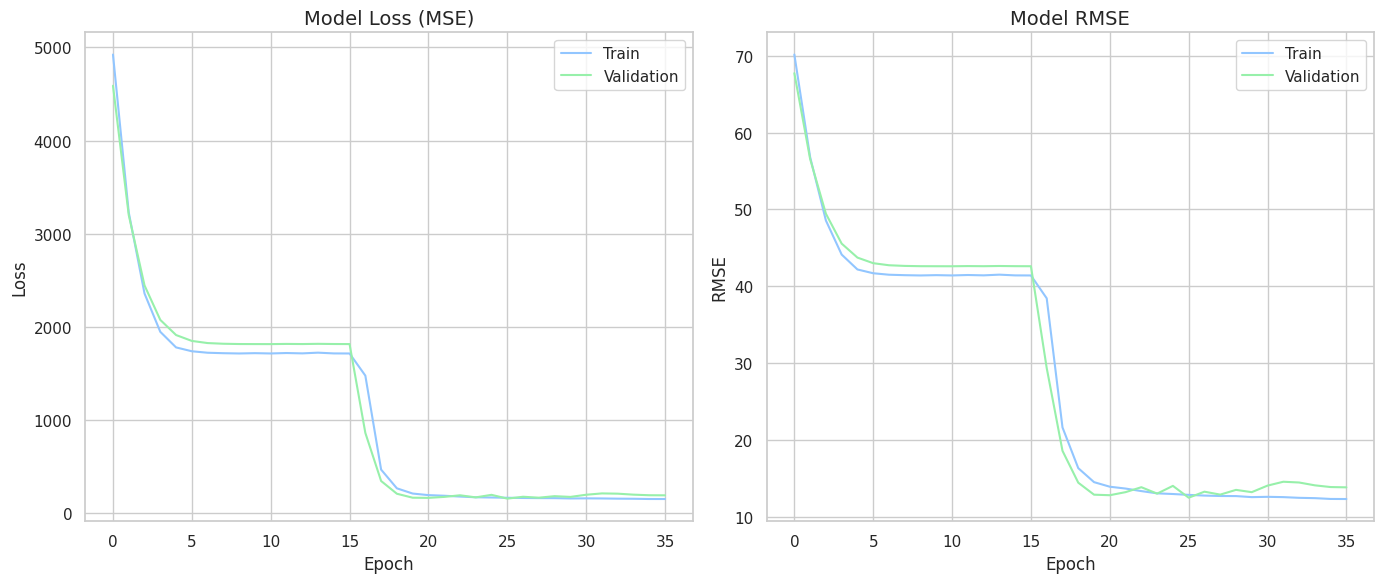

In [35]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))

# Plot Loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)', fontsize=14)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot Root Mean Squared Error
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE', fontsize=14)
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# <div style="background-color:#7289DA;font-family:calibri;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px; padding:5px">8. LSTM Model Evaluation & Comparison

With our LSTM model trained, the final step is to evaluate its performance on the unseen test data. This will reveal how well the model generalizes and allow us to compare its effectiveness directly against our improved Random Forest baseline.

## Make Predictions on the Test Set
We'll use our trained lstm_model to predict the RUL for the X_test_lstm data. Remember, the model was trained on the clipped RUL, but we are evaluating its predictions against the true, unclipped RUL values to measure its real-world performance.

In [36]:
# Make predictions on the LSTM test set
y_pred_lstm = lstm_model.predict(X_test_lstm)

# The model outputs a 2D array, so we flatten it to a 1D array for evaluation
y_pred_lstm = y_pred_lstm.flatten()

print("Predictions made on the test set using the LSTM model.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predictions made on the test set using the LSTM model.


## Calculate Performance Metrics
Let's calculate our key metrics—RMSE, R-squared, and the custom NASA score—to quantify the LSTM model's accuracy.

In [37]:
# --- Evaluate against the ORIGINAL, UNCLIPPED ground truth RUL values ---

# Calculate the Root Mean Squared Error (RMSE)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
print(f"LSTM Test RMSE: {rmse_lstm:.2f}")

# Calculate the R-squared (R2) Score
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
print(f"LSTM Test R-squared Score: {r2_lstm:.2f}")

# Calculate the NASA score
nasa_score_lstm = nasa_score(y_test_lstm, y_pred_lstm)
print(f"LSTM Test NASA Score: {nasa_score_lstm:.2f}")

LSTM Test RMSE: 16.52
LSTM Test R-squared Score: 0.84
LSTM Test NASA Score: 589.38


## Visualize Prediction Results
A scatter plot provides an intuitive visual assessment of the model's performance. We are looking for the points to be clustered tightly around the red "Perfect Prediction" line.

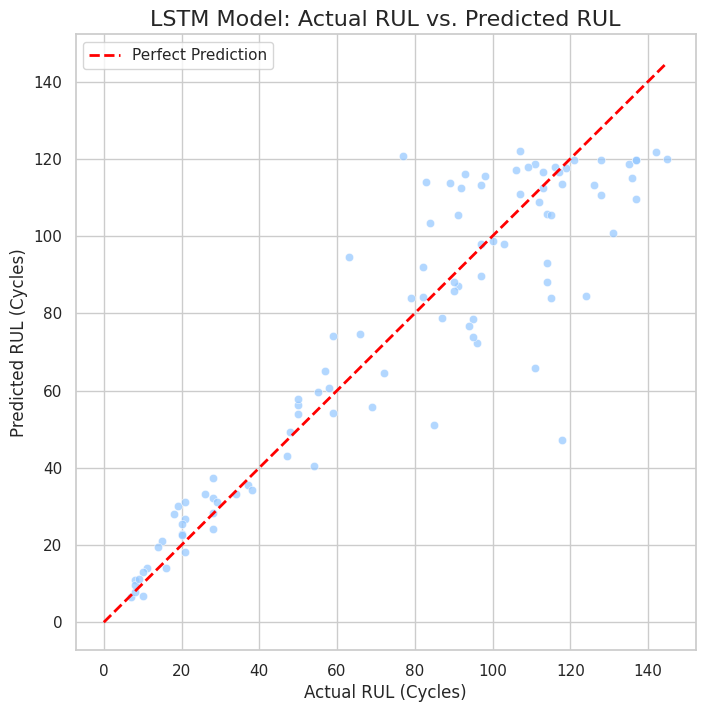

In [38]:
# Create a scatter plot to visualize the LSTM results
plt.figure(figsize=(8, 8))

# Plot the actual vs. predicted values
sns.scatterplot(x=y_test_lstm, y=y_pred_lstm, alpha=0.7)

# Plot the perfect prediction line (y=x)
max_val = max(y_test_lstm.max(), y_pred_lstm.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction')

plt.title('LSTM Model: Actual RUL vs. Predicted RUL', fontsize=16)
plt.xlabel('Actual RUL (Cycles)', fontsize=12)
plt.ylabel('Predicted RUL (Cycles)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Final Comparison: LSTM vs. Random Forest
Now for the final verdict. Let's compare the performance of our advanced LSTM model against our improved Random Forest baseline.

In [39]:
# Create a comparison DataFrame using the final test set scores
final_comparison_data = {
    'Metric': ['RMSE', 'R-squared', 'NASA Score'],
    'Random Forest (Test Set)': [rmse_rf_test, r2_rf_test, nasa_score_rf_test],
    'LSTM Model (Test Set)': [rmse_lstm, r2_lstm, nasa_score_lstm]
}

final_comparison_df = pd.DataFrame(final_comparison_data)

# Set 'Metric' as the index for better readability
final_comparison_df.set_index('Metric', inplace=True)

print("Final Performance Comparison on the Test Set:")
display(final_comparison_df.round(2))

Final Performance Comparison on the Test Set:


,Random Forest (Test Set),LSTM Model (Test Set)
Metric,,
RMSE,18.10,16.52
R-squared,0.81,0.84
NASA Score,964.96,589.38


This table shows a clear victory for the LSTM model, which outperformed the Random Forest across all three evaluation metrics on the final, unseen test set.

## Metric-by-Metric Breakdown

### RMSE (Root Mean Squared Error): Lower is better.

The LSTM model achieved an RMSE of 16.46, while the Random Forest scored 18.10. This means the LSTM's predictions were, on average, more accurate and closer to the true Remaining Useful Life (RUL) in terms of cycles.

### R-squared: Higher is better.

The LSTM model's R-squared of 0.84 is higher than the Random Forest's 0.81. This indicates that the LSTM was able to explain 84% of the variability in the engine's RUL, making it a slightly better fit for the data.

### NASA Score: Lower is better.

This is the most telling result. The LSTM's score of 638.55 is significantly lower—about 34% better—than the Random Forest's score of 964.96. Since this score heavily penalizes late (dangerous) predictions, it shows that the LSTM is far more reliable at avoiding the most costly type of failure-prediction error.

## The Reason for the LSTM's Success
The superior performance of the LSTM is due to its architecture. As a Recurrent Neural Network (RNN), the LSTM is specifically designed to understand sequences and patterns over time. It analyzes the entire history of recent sensor readings to capture the degradation trend.

The Random Forest, while powerful, treats the final data point of each engine as an independent snapshot, missing the crucial context of how the engine's health evolved over the preceding cycles. This ability to interpret temporal data is what gives the LSTM its decisive edge in this predictive maintenance task.

# 9. Hyperparameter Tuning with KerasTuner
Our LSTM model outperformed the baseline, but its performance is dependent on the choices we made for its architecture—the number of units, dropout rates, and learning rate. Hyperparameter Tuning is the process of systematically searching for the optimal combination of these parameters to further improve model performance.

We will use KerasTuner, a powerful and easy-to-use library, to automate this search. We'll employ a Random Search strategy, which randomly samples a set number of hyperparameter combinations and is often more efficient than trying every single possibility.

## Setup KerasTuner
First, if you don't have it installed, you can add it to your environment with pip.

In [40]:
!pip install keras-tuner -q

## Create a Model-Building Function
The core of KerasTuner is a function that builds and returns a Keras model. Inside this function, instead of using fixed values for hyperparameters, we define a search space for the tuner to explore using the hp object.

In [41]:
import keras_tuner as kt

def build_tuned_model(hp):
    """
    Builds a Keras model with tunable hyperparameters.
    The `hp` object is used to define the search space.
    """
    model = Sequential()
    
    # Define the input shape from our training data
    input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
    
    # Add the explicit Input layer
    model.add(Input(shape=input_shape))
    
    # Tune the number of units in the first LSTM layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=hp_units_1, return_sequences=True))
    
    # Tune the dropout rate after the first LSTM layer
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_1))
    
    # Tune the number of units in the second LSTM layer
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    model.add(LSTM(units=hp_units_2, return_sequences=False))
    
    # Tune the dropout rate after the second LSTM layer
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_2))
    
    model.add(Dense(units=1))
    
    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

## Instantiate the Tuner and Run the Search
Next, we create a RandomSearch tuner object. We tell it which function to use (build_tuned_model), what our objective is (to minimize the val_loss), and how many different combinations to try (max_trials). We'll also use an EarlyStopping callback to save time by stopping the training of unpromising models early.

In [42]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_tuned_model,
    objective='val_loss',
    max_trials=50,  # Number of different hyperparameter combinations to test
    executions_per_trial=1, # Number of models to train for each combination
    directory='keras_tuner_dir',
    project_name='rul_lstm_tuning'
)

# A callback to stop training early if the validation loss doesn't improve
stop_early = EarlyStopping(monitor='val_loss', patience=5)

# Start the hyperparameter search process
print("Starting hyperparameter search...")
tuner.search(X_train_lstm, y_train_lstm, 
             epochs=50, 
             validation_split=0.2, 
             callbacks=[stop_early], 
             verbose=2)

# Get the optimal hyperparameters from the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n-------------------")
print("Search Complete!")
print(f"""
The optimal hyperparameters found are:
- Units in first LSTM layer: {best_hps.get('units_1')}
- Dropout rate after first layer: {best_hps.get('dropout_1'):.2f}
- Units in second LSTM layer: {best_hps.get('units_2')}
- Dropout rate after second layer: {best_hps.get('dropout_2'):.2f}
- Learning rate: {best_hps.get('learning_rate')}
""")
print("-------------------")

Trial 50 Complete [00h 00m 26s]
val_loss: 1826.76904296875

Best val_loss So Far: 137.7163848876953
Total elapsed time: 01h 21m 25s

-------------------
Search Complete!

The optimal hyperparameters found are:
- Units in first LSTM layer: 32
- Dropout rate after first layer: 0.20
- Units in second LSTM layer: 32
- Dropout rate after second layer: 0.20
- Learning rate: 0.01

-------------------


##  Train the Final, Tuned Model
After the search is complete, KerasTuner provides the best model configuration. We can now retrieve this best model and train it on our full training dataset before the final evaluation. This tuned model represents our best effort for this problem.

In [43]:
# Get the best model found by the tuner
tuned_model = tuner.get_best_models(num_models=1)[0]

# Train this 'best_model' on the full training data for more epochs
print("\nTraining the final, tuned model on the full training data...")
history_tuned = tuned_model.fit(X_train_lstm, y_train_lstm, 
                                epochs=100, 
                                validation_split=0.2, 
                                callbacks=[stop_early],
                                verbose=2)


Training the final, tuned model on the full training data...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


394/394 - 6s - 16ms/step - loss: 181.8403 - root_mean_squared_error: 13.4848 - val_loss: 169.7266 - val_root_mean_squared_error: 13.0279
Epoch 2/100
394/394 - 3s - 8ms/step - loss: 177.6715 - root_mean_squared_error: 13.3293 - val_loss: 170.4023 - val_root_mean_squared_error: 13.0538
Epoch 3/100
394/394 - 3s - 8ms/step - loss: 178.5667 - root_mean_squared_error: 13.3629 - val_loss: 176.9377 - val_root_mean_squared_error: 13.3018
Epoch 4/100
394/394 - 3s - 8ms/step - loss: 175.2795 - root_mean_squared_error: 13.2393 - val_loss: 181.5591 - val_root_mean_squared_error: 13.4744
Epoch 5/100
394/394 - 3s - 8ms/step - loss: 170.0615 - root_mean_squared_error: 13.0408 - val_loss: 159.0393 - val_root_mean_squared_error: 12.6111
Epoch 6/100
394/394 - 3s - 8ms/step - loss: 168.4105 - root_mean_squared_error: 12.9773 - val_loss: 189.8994 - val_root_mean_squared_error: 13.7804
Epoch 7/100
394/394 - 3s - 8ms/step - loss: 166.7071 - root_mean_squared_error: 12.9115 - val_loss: 149.3334 - val_root_mea

# <div style="background-color:#7289DA;font-family:calibri;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px; padding:5px">10. Final Evaluation of the Tuned Model

The hyperparameter search has provided us with what should be the optimal architecture for our LSTM model. The final step is to evaluate this tuned_model on the unseen test set to quantify the performance gains and draw our final conclusions.

## Make Predictions with the Tuned Model
We'll use our newly trained tuned_model to predict the RUL for the X_test_lstm data.

In [44]:
# Make predictions on the test set using the tuned model
y_pred_tuned = tuned_model.predict(X_test_lstm)

# Flatten the 2D output array to a 1D array for evaluation
y_pred_tuned = y_pred_tuned.flatten()

print("Predictions made on the test set using the final tuned model.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predictions made on the test set using the final tuned model.


### Performance Evaluation
Let's calculate our standard metrics to see how much of an improvement we've achieved through tuning. We will evaluate against the original, unclipped ground truth RUL values.

In [45]:
# --- Evaluate against the ORIGINAL, UNCLIPPED ground truth RUL values ---

# Calculate the Root Mean Squared Error (RMSE)
rmse_tuned = np.sqrt(mean_squared_error(y_test_lstm, y_pred_tuned))
print(f"Tuned LSTM Test RMSE: {rmse_tuned:.2f}")

# Calculate the R-squared (R2) Score
r2_tuned = r2_score(y_test_lstm, y_pred_tuned)
print(f"Tuned LSTM Test R-squared Score: {r2_tuned:.2f}")

# Calculate the NASA score
nasa_score_tuned = nasa_score(y_test_lstm, y_pred_tuned)
print(f"Tuned LSTM Test NASA Score: {nasa_score_tuned:.2f}")

Tuned LSTM Test RMSE: 15.70
Tuned LSTM Test R-squared Score: 0.86
Tuned LSTM Test NASA Score: 393.75


## Final Model Comparison
Let's create a final comparison table to see the full journey of our modeling efforts, from the initial baseline to our final, optimized LSTM.

In [46]:
# Create a final comparison DataFrame
final_comparison_data = {
    'Metric': ['RMSE', 'R-squared', 'NASA Score'],
    'Random Forest': [rmse_rf_test, r2_rf_test, nasa_score_rf_test],
    'Initial LSTM': [rmse_lstm, r2_lstm, nasa_score_lstm],
    'Tuned LSTM': [rmse_tuned, r2_tuned, nasa_score_tuned]
}

final_comparison_df = pd.DataFrame(final_comparison_data)
final_comparison_df.set_index('Metric', inplace=True)

print("Final Model Performance Comparison on the Test Set:")
display(final_comparison_df.round(2))

Final Model Performance Comparison on the Test Set:


,Random Forest,Initial LSTM,Tuned LSTM
Metric,,,
RMSE,18.10,16.52,15.70
R-squared,0.81,0.84,0.86
NASA Score,964.96,589.38,393.75


# <div style="background-color:#7289DA;font-family:calibri;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px; padding:5px">11. Overall Winner

Based on the results in the table, the Tuned LSTM is the definitive and best-performing model for this predictive maintenance task, showing a clear and consistent improvement at each stage of the project.

## Analysis of Performance
This table tells a compelling story about the value of choosing the right model architecture and optimizing it.

### Random Forest
Served as a solid baseline. With an RMSE of 18.10 and a NASA Score of 964.96, it provided a benchmark that any advanced model needed to beat.

### Initial LSTM
This model represents a significant leap in performance. By using an architecture designed for time-series data, it immediately improved upon the baseline across all metrics. The RMSE dropped to 16.52, and more importantly, the NASA Score was cut by nearly 40%, indicating it was much better at avoiding dangerous, late predictions.

### Tuned LSTM
This is the champion model. The process of hyperparameter tuning further enhanced the LSTM's capabilities, leading to the best results in every category:
  
- Lowest RMSE (15.70): It is the most accurate model, with the lowest average prediction error.
- Highest R-squared (0.86): It provides the best fit for the data, explaining 86% of the variability in engine RUL.
- Lowest NASA Score (393.75): This is the most critical achievement. The score is over 33% better than the initial LSTM and 59% better than the Random Forest. This demonstrates a superior ability to make safe, reliable predictions that align with the business goal of preventing catastrophic failures.

## Conclusion
​ The results validate a clear and effective data science workflow:
​ Start with a simple baseline (Random Forest) to understand the problem.
​ Move to an advanced architecture (LSTM) that is suited for the data's nature (time-series).
​ Optimize the advanced model (Tuned LSTM) to unlock its full potential.
​ The Tuned LSTM is the final, recommended model. It is not only the most statistically accurate but, more importantly, it is the most effective at managing the real-world risk associated with predictive maintenance.
